
Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3526, number of negative: 4474
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1335
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

LightGBM Results:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1118
           1       0.96      0.97      0.97       882

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      200

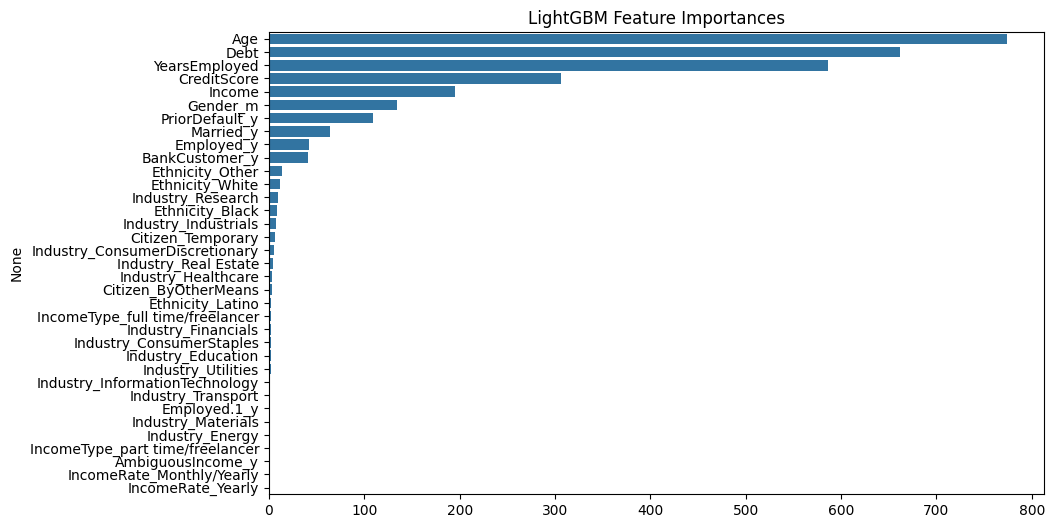


Training Logistic GAM...


C:\Users\Adith\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygam\links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
C:\Users\Adith\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygam\pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2



Logistic GAM Results:
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      1118
           1       0.83      0.89      0.86       882

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000

Accuracy: 0.871
ROC AUC: 0.9458530579793039


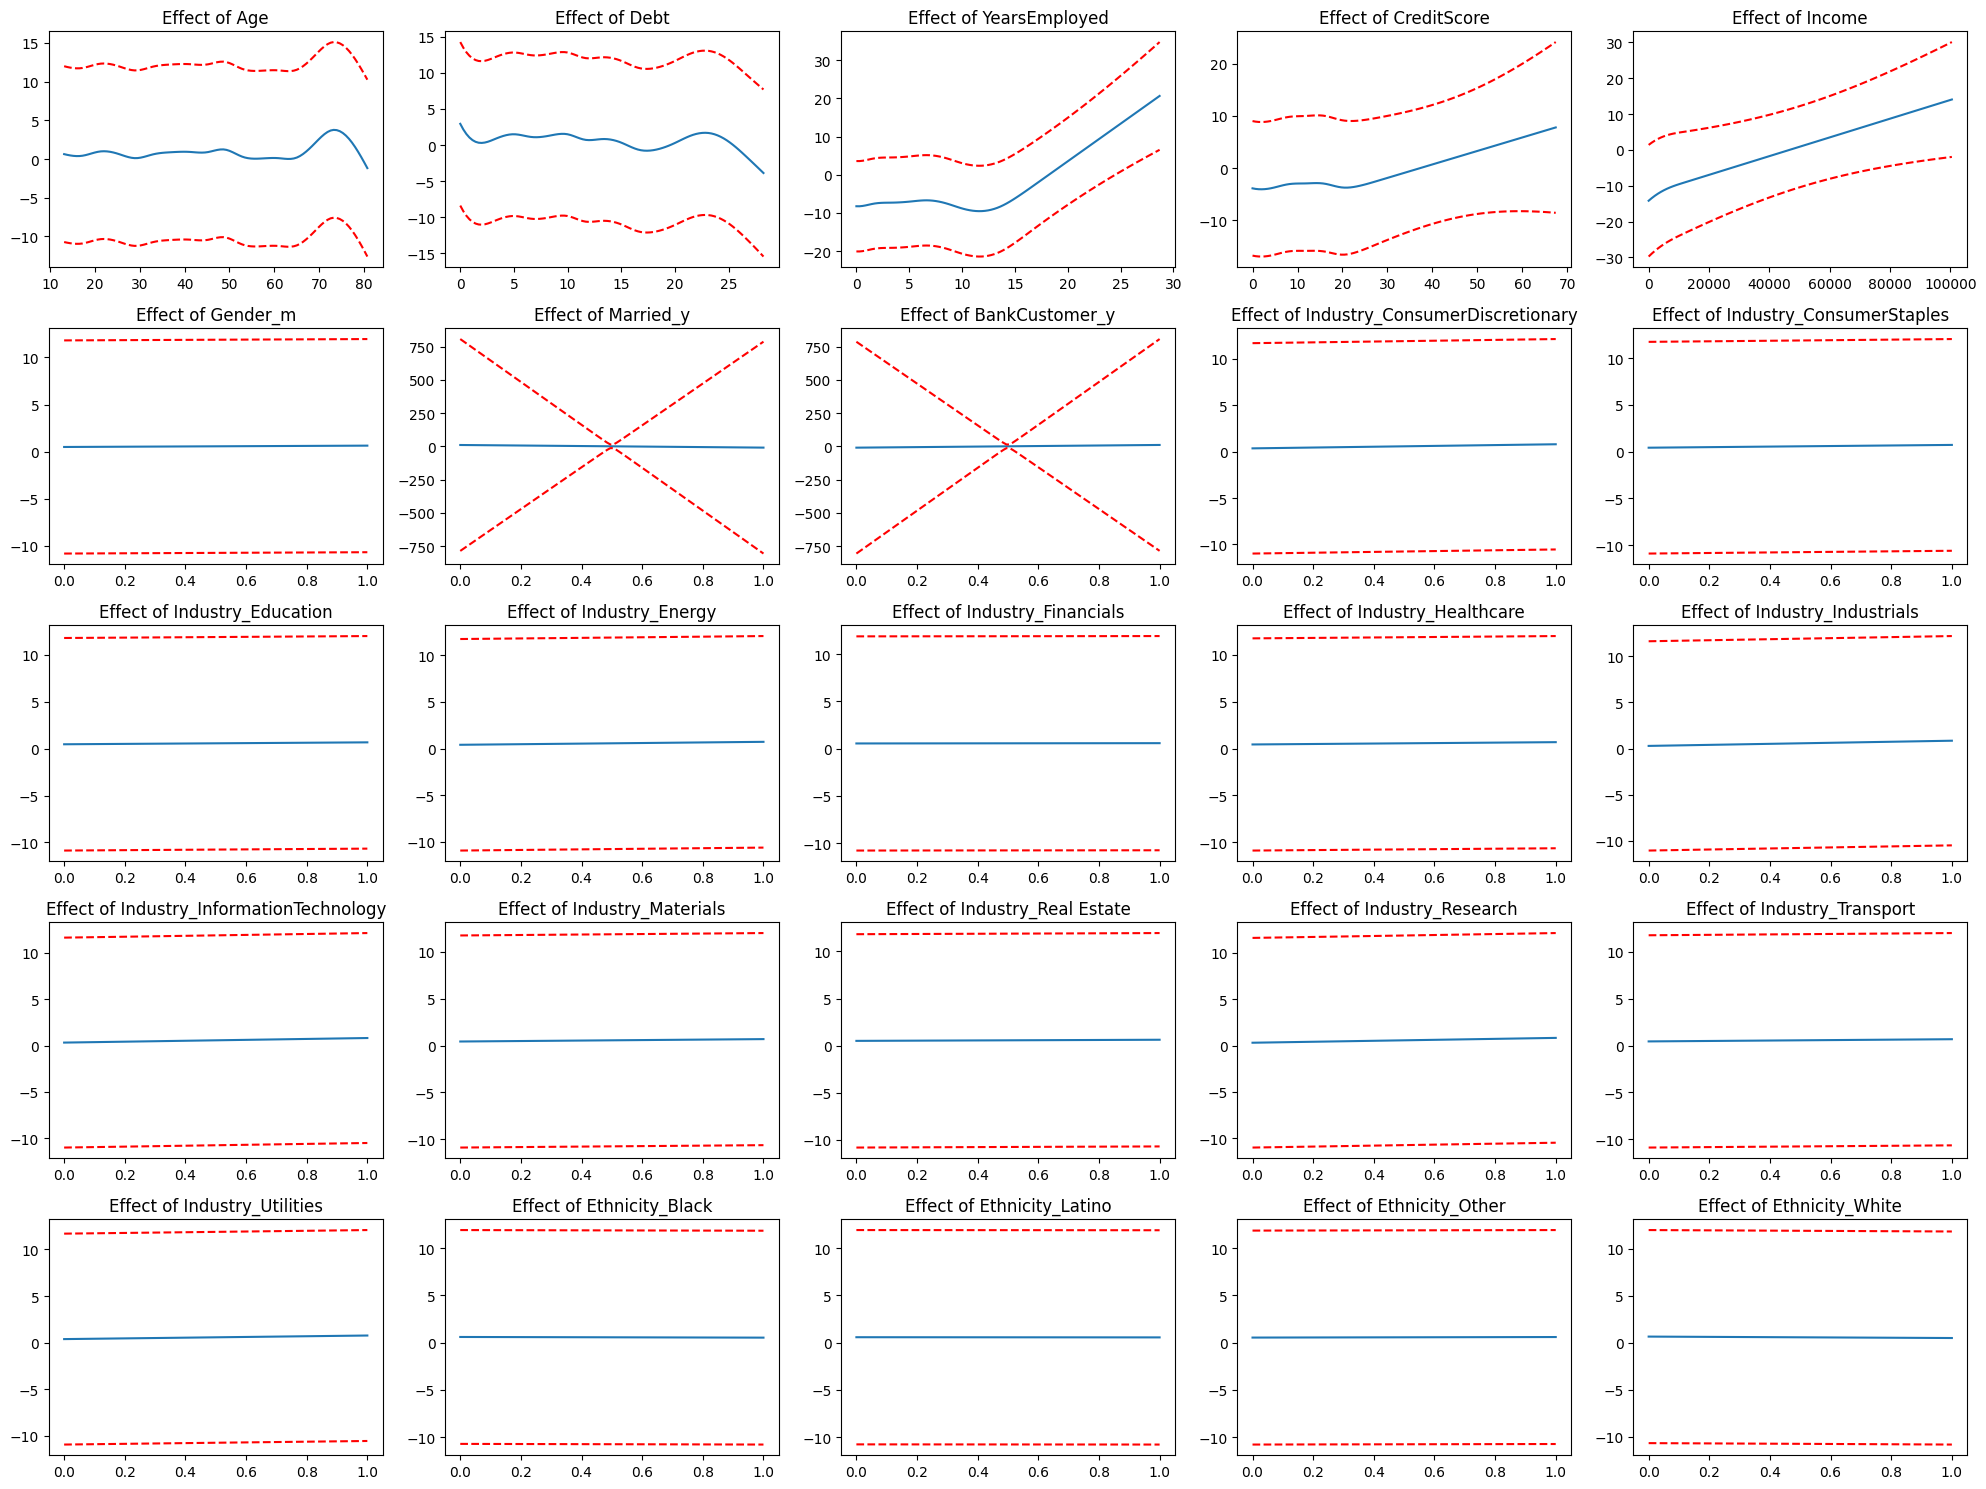


Ensemble Results (LightGBM + GAM):
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1118
           1       0.93      0.94      0.94       882

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000

Accuracy: 0.9445
ROC AUC: 0.9877869454281414


<Figure size 800x600 with 0 Axes>

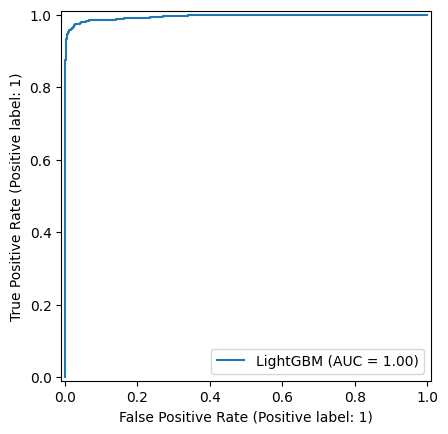

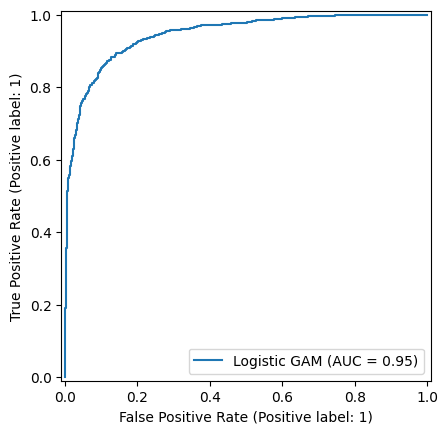

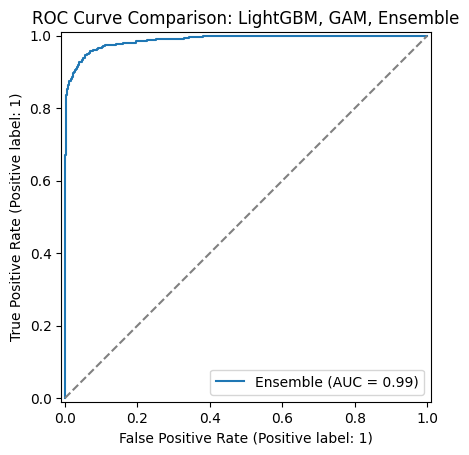

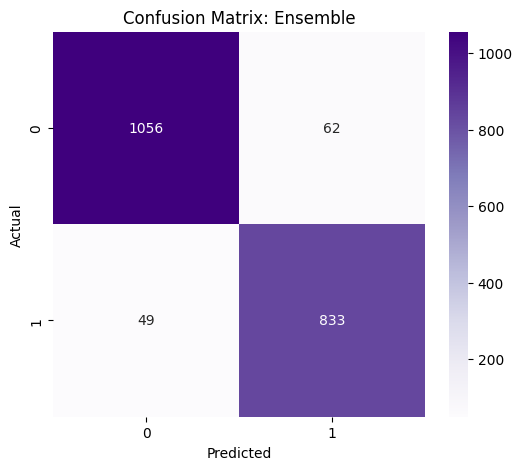

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, RocCurveDisplay
import lightgbm as lgb
from pygam import LogisticGAM, s
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================
# Load dataset
# ============================================
file_path = r"C:\Users\Adith\Downloads\FINAL_DATASET.csv"
df = pd.read_csv(file_path)

# Encode target column (Approved: y/n -> 1/0)
df["Approved"] = df["Approved"].map({"y": 1, "n": 0})

# Handle categorical variables with one-hot encoding
X = df.drop("Approved", axis=1)
y = df["Approved"]

X = pd.get_dummies(X, drop_first=True)

# Fill missing values (if any)
X = X.fillna(0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ============================================
# LightGBM Model
# ============================================
print("\nTraining LightGBM...")
lgb_model = lgb.LGBMClassifier(
    random_state=42,
    class_weight="balanced"   # <--- add this
)
lgb_model.fit(X_train, y_train)


y_pred_lgb = lgb_model.predict(X_test)
y_prob_lgb = lgb_model.predict_proba(X_test)[:, 1]

print("\nLightGBM Results:")
print(classification_report(y_test, y_pred_lgb))
print("Accuracy:", accuracy_score(y_test, y_pred_lgb))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lgb))

# Feature Importance Plot
feat_importances = pd.Series(lgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feat_importances.values, y=feat_importances.index)
plt.title("LightGBM Feature Importances")
plt.show()

# ============================================
# Logistic GAM Model
# ============================================
# Build GAM terms correctly using reduce
terms = reduce(lambda a, b: a + b, [s(i) for i in range(X_train.shape[1])])

print("\nTraining Logistic GAM...")
gam = LogisticGAM(terms).fit(X_train.values, y_train.values)

y_pred_gam = gam.predict(X_test.values)
y_prob_gam = gam.predict_proba(X_test.values)

print("\nLogistic GAM Results:")
print(classification_report(y_test, y_pred_gam))
print("Accuracy:", accuracy_score(y_test, y_pred_gam))
print("ROC AUC:", roc_auc_score(y_test, y_prob_gam))

# Partial Dependence / Feature Effect Plots
plt.figure(figsize=(20, 15))
for i, col in enumerate(X_train.columns[:25]):  # limit to first 25 features
    plt.subplot(5, 5, i + 1)
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=0.95)[1], c='r', ls='--')
    plt.title(f'Effect of {col}')
plt.tight_layout()
plt.show()

# ============================================
# Ensemble: Combine LightGBM & GAM
# ============================================
combined_prob = (y_prob_lgb + y_prob_gam) / 2
combined_pred = (combined_prob > 0.5).astype(int)
print("\nEnsemble Results (LightGBM + GAM):")
print(classification_report(y_test, combined_pred))
print("Accuracy:", accuracy_score(y_test, combined_pred))
print("ROC AUC:", roc_auc_score(y_test, combined_prob))

# ============================================
# ROC Curve Comparison
# ============================================
plt.figure(figsize=(8,6))
RocCurveDisplay.from_predictions(y_test, y_prob_lgb, name="LightGBM")
RocCurveDisplay.from_predictions(y_test, y_prob_gam, name="Logistic GAM")
RocCurveDisplay.from_predictions(y_test, combined_prob, name="Ensemble")
plt.plot([0,1],[0,1],'--',color='gray')
plt.title("ROC Curve Comparison: LightGBM, GAM, Ensemble")
plt.show()

# ============================================
# Confusion Matrix for Ensemble
# ============================================
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, combined_pred), annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix: Ensemble")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [2]:
# ============================================
# Prediction on a new applicant
# ============================================

# Example applicant details (change values as needed)
new_applicant = pd.DataFrame([{
    "Gender": "f",
    "Age": 65,
    "Debt": 0,
    "Married": "y",
    "BankCustomer": "y",
    "Industry": "Industrials",
    "Ethnicity": "White",
    "YearsEmployed": 4.0,
    "PriorDefault": "n",
    "CreditScore": 6.0,
    "Employed": "y",
    "Citizen": "ByBirth",
    "Income": 500000.0,
    "IncomeType": "salaried",
    "AmbiguousIncome": "n",
    "IncomeRate": "Monthly"
}])

# One-hot encode to match training
new_applicant = pd.get_dummies(new_applicant, drop_first=True)

# Align columns with LightGBM’s training features
feature_names = lgb_model.booster_.feature_name()
new_applicant = new_applicant.reindex(columns=feature_names, fill_value=0)

# LightGBM prediction
pred_lgb = lgb_model.predict(new_applicant)[0]
prob_lgb = lgb_model.predict_proba(new_applicant)[0][1]

# GAM prediction
pred_gam = gam.predict(new_applicant.values)[0]
prob_gam = gam.predict_proba(new_applicant.values)[0]

# Ensemble prediction
combined_prob = (prob_lgb + prob_gam) / 2
combined_pred = int(combined_prob > 0.5)

print("LightGBM Prediction:", pred_lgb, "Prob:", prob_lgb)
print("GAM Prediction:", pred_gam, "Prob:", prob_gam)
print("Ensemble Prediction:", combined_pred, "Prob:", combined_prob)


LightGBM Prediction: 0 Prob: 0.07009058559033726
GAM Prediction: True Prob: 1.0
Ensemble Prediction: 1 Prob: 0.5350452927951687



Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3526, number of negative: 4474
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1335
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

LightGBM Results:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1118
           1       0.96      0.97      0.97       882

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      200

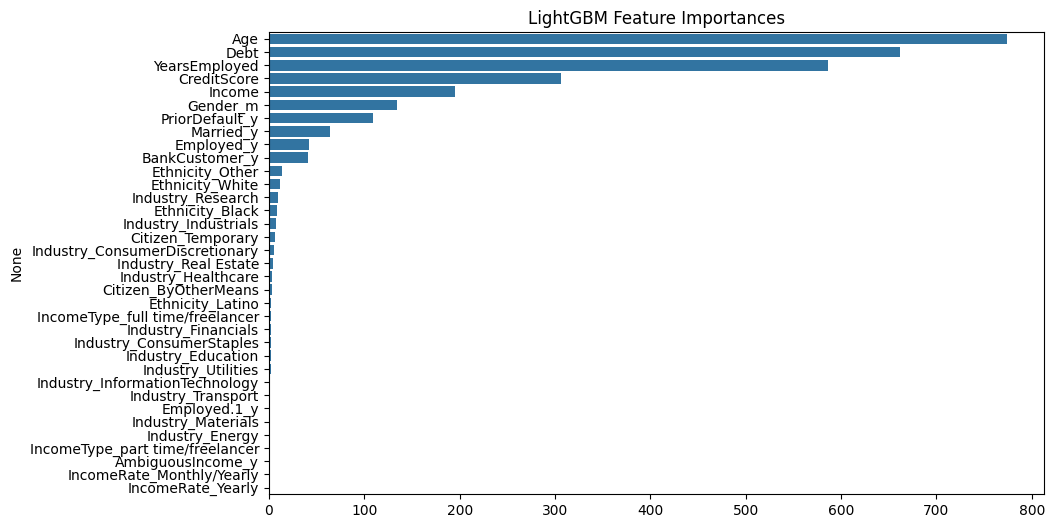


Training Logistic GAM with class balancing...


C:\Users\Adith\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygam\links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
C:\Users\Adith\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygam\pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2



Logistic GAM Results:
              precision    recall  f1-score   support

           0       0.92      0.84      0.88      1118
           1       0.82      0.90      0.86       882

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000

Accuracy: 0.8675
ROC AUC: 0.9474482697074058


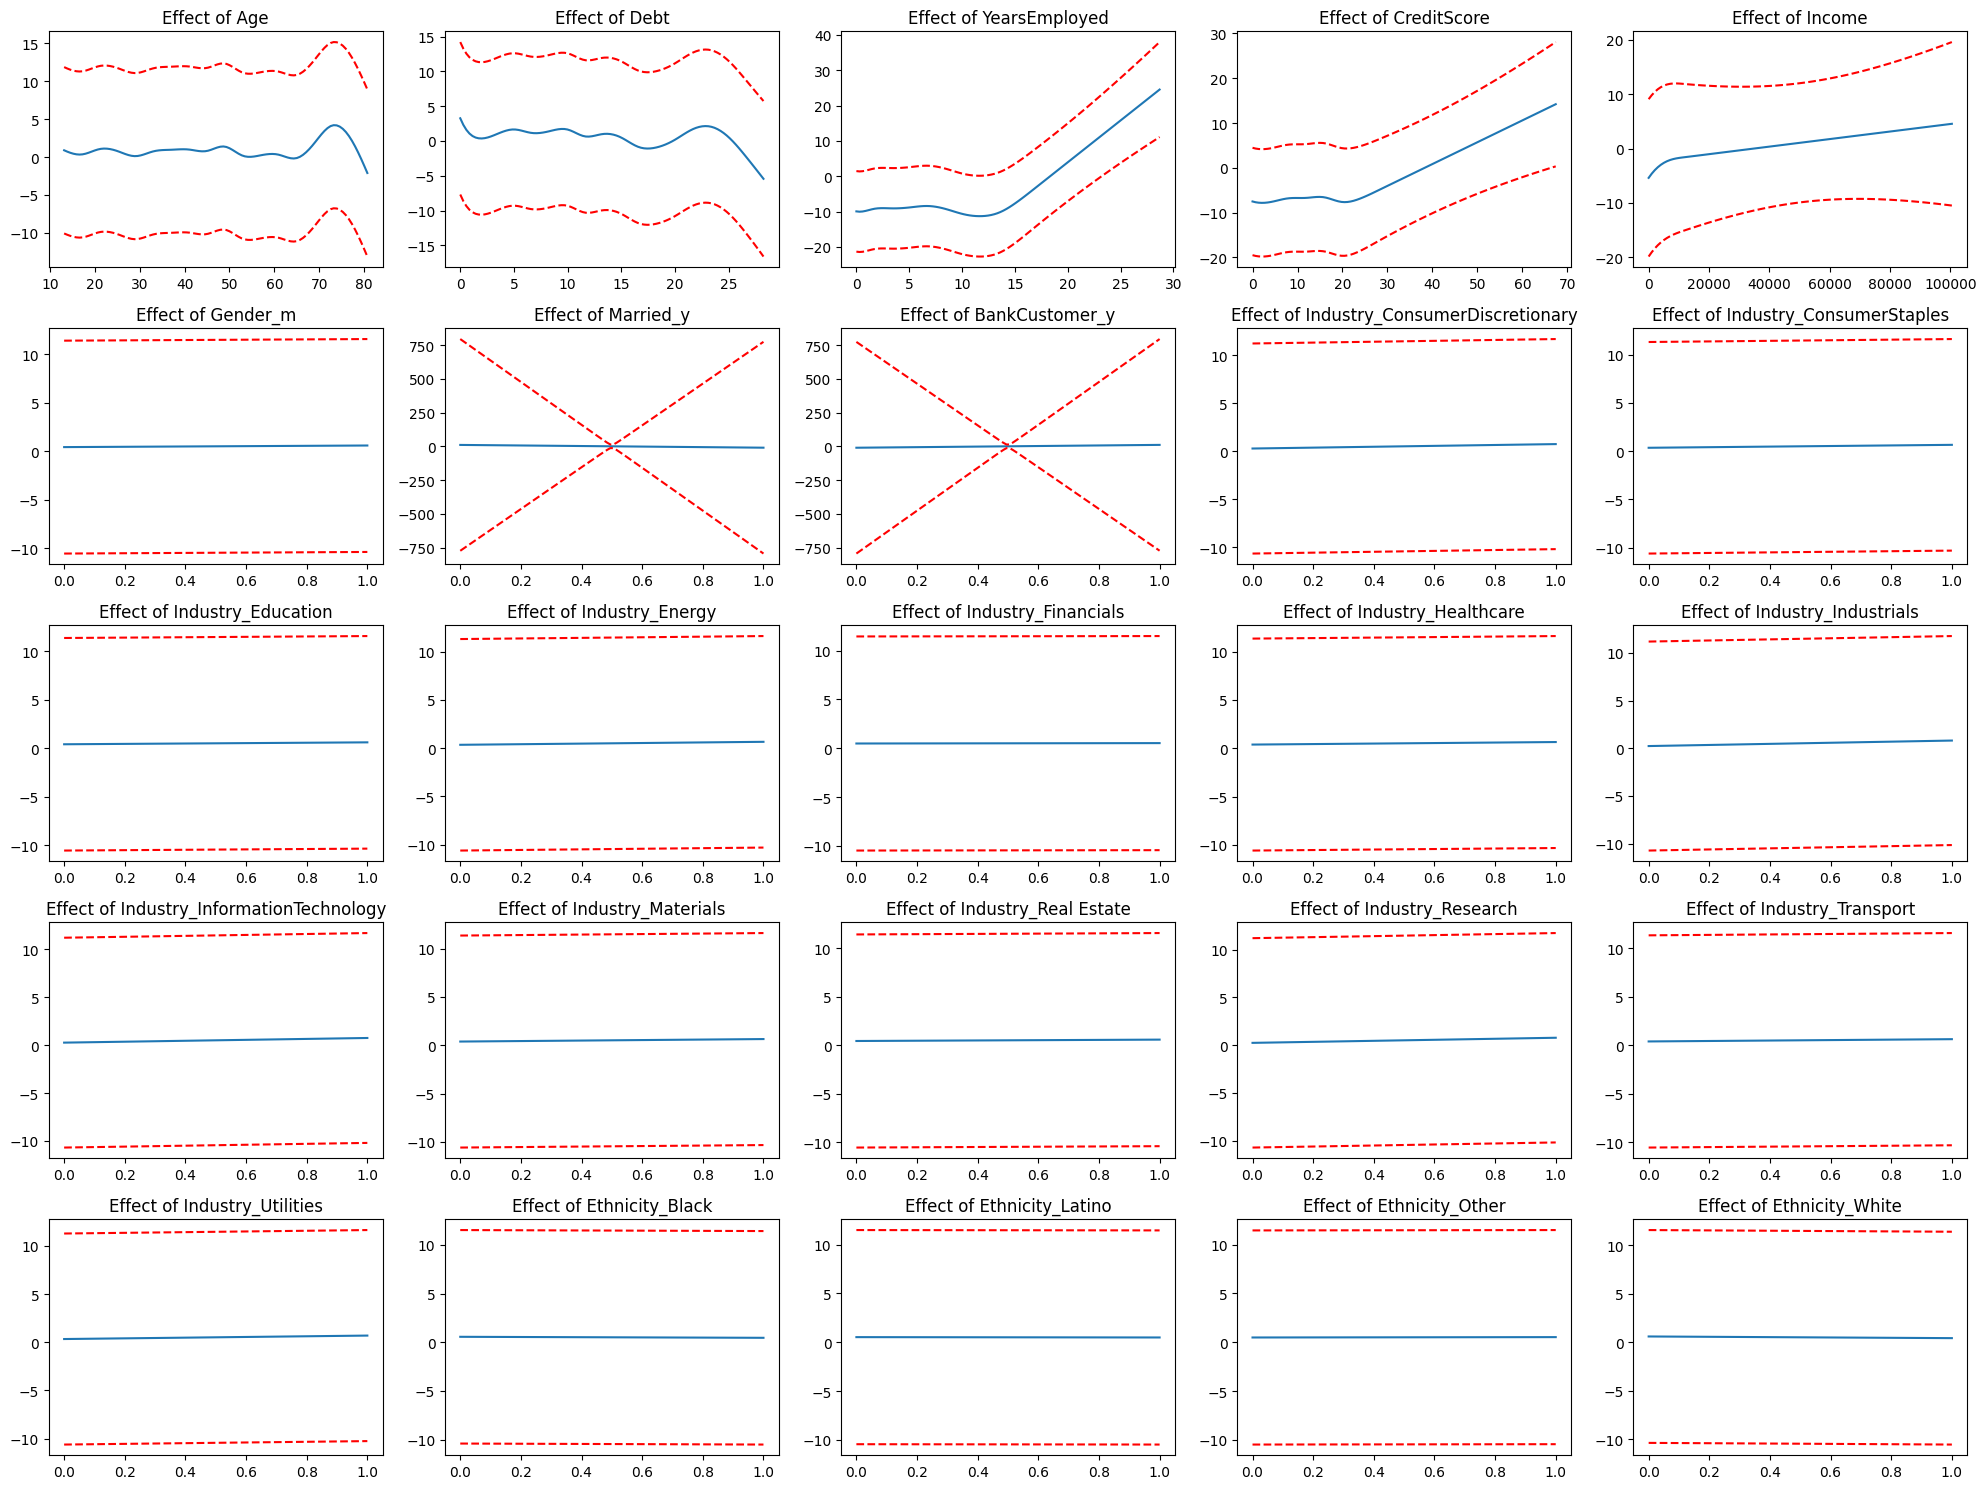


Ensemble Results (LightGBM + GAM):
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1118
           1       0.92      0.95      0.94       882

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000

Accuracy: 0.9425
ROC AUC: 0.9878122984435277


<Figure size 800x600 with 0 Axes>

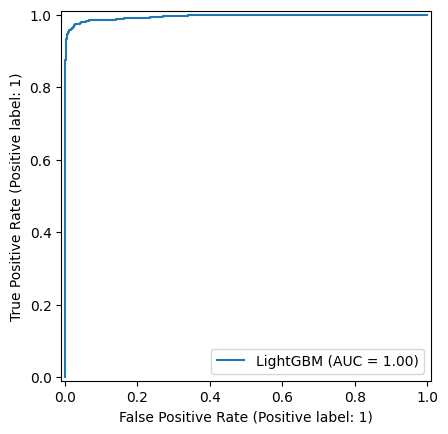

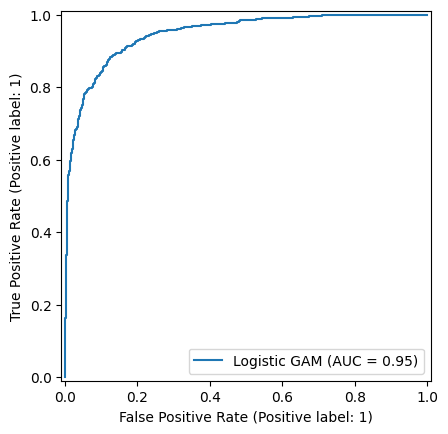

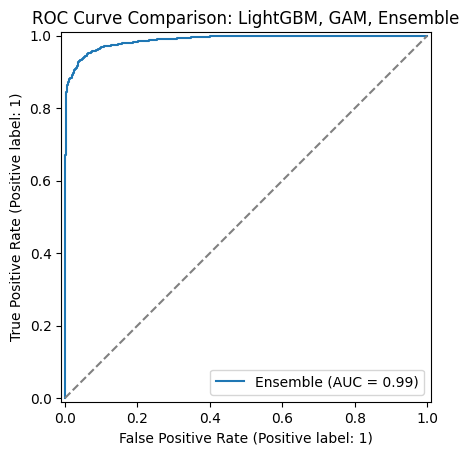

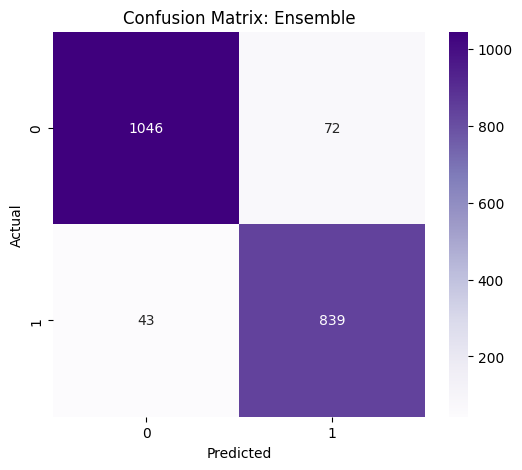

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, RocCurveDisplay
import lightgbm as lgb
from pygam import LogisticGAM, s
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================
# Load dataset
# ============================================
file_path = r"C:\Users\Adith\Downloads\FINAL_DATASET.csv"
df = pd.read_csv(file_path)

# Encode target column (Approved: y/n -> 1/0)
df["Approved"] = df["Approved"].map({"y": 1, "n": 0})

# Handle categorical variables with one-hot encoding
X = df.drop("Approved", axis=1)
y = df["Approved"]
X = pd.get_dummies(X, drop_first=True)

# Fill missing values
X = X.fillna(0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ============================================
# LightGBM Model with class balancing
# ============================================
print("\nTraining LightGBM...")
lgb_model = lgb.LGBMClassifier(
    random_state=42,
    class_weight="balanced"  # class balancing
)
lgb_model.fit(X_train, y_train)

y_pred_lgb = lgb_model.predict(X_test)
y_prob_lgb = lgb_model.predict_proba(X_test)[:, 1]

print("\nLightGBM Results:")
print(classification_report(y_test, y_pred_lgb))
print("Accuracy:", accuracy_score(y_test, y_pred_lgb))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lgb))

# Feature Importance Plot
feat_importances = pd.Series(lgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feat_importances.values, y=feat_importances.index)
plt.title("LightGBM Feature Importances")
plt.show()

# ============================================
# Logistic GAM Model with class balancing
# ============================================
# Compute sample weights based on class frequency
class_counts = y_train.value_counts()
total = len(y_train)
class_weights = {0: total / class_counts[0], 1: total / class_counts[1]}
sample_weights = y_train.map(class_weights)

# Build GAM terms
terms = reduce(lambda a, b: a + b, [s(i) for i in range(X_train.shape[1])])

print("\nTraining Logistic GAM with class balancing...")
gam = LogisticGAM(terms).fit(X_train.values, y_train.values, weights=sample_weights.values)

y_pred_gam = gam.predict(X_test.values)
y_prob_gam = gam.predict_proba(X_test.values)

print("\nLogistic GAM Results:")
print(classification_report(y_test, y_pred_gam))
print("Accuracy:", accuracy_score(y_test, y_pred_gam))
print("ROC AUC:", roc_auc_score(y_test, y_prob_gam))

# Partial Dependence / Feature Effect Plots
plt.figure(figsize=(20, 15))
for i, col in enumerate(X_train.columns[:25]):  # limit to first 25 features
    plt.subplot(5, 5, i + 1)
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=0.95)[1], c='r', ls='--')
    plt.title(f'Effect of {col}')
plt.tight_layout()
plt.show()

# ============================================
# Ensemble: Combine LightGBM & GAM
# ============================================
combined_prob = (y_prob_lgb + y_prob_gam) / 2
combined_pred = (combined_prob > 0.5).astype(int)

print("\nEnsemble Results (LightGBM + GAM):")
print(classification_report(y_test, combined_pred))
print("Accuracy:", accuracy_score(y_test, combined_pred))
print("ROC AUC:", roc_auc_score(y_test, combined_prob))

# ============================================
# ROC Curve Comparison
# ============================================
plt.figure(figsize=(8,6))
RocCurveDisplay.from_predictions(y_test, y_prob_lgb, name="LightGBM")
RocCurveDisplay.from_predictions(y_test, y_prob_gam, name="Logistic GAM")
RocCurveDisplay.from_predictions(y_test, combined_prob, name="Ensemble")
plt.plot([0,1],[0,1],'--',color='gray')
plt.title("ROC Curve Comparison: LightGBM, GAM, Ensemble")
plt.show()

# ============================================
# Confusion Matrix for Ensemble
# ============================================
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, combined_pred), annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix: Ensemble")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [8]:
# Example new applicant (fill with real values)
new_data = pd.DataFrame([{
    "Gender": "f",
    "Age": 35,
    "Debt": 2.5,
    "Married": "y",
    "BankCustomer": "y",
    "Industry": "Industrials",
    "Ethnicity": "White",
    "YearsEmployed": 4.0,
    "PriorDefault": "n",
    "CreditScore": 6.0,
    "Employed": "y",
    "Citizen": "ByBirth",
    "Income": 50000.0,
    "IncomeType": "salaried",
    "AmbiguousIncome": "n",
    "IncomeRate": "Monthly"
}])

# Preprocess same as training
new_data = pd.get_dummies(new_data, drop_first=True)
new_data = new_data.reindex(columns=X_train.columns, fill_value=0)

# Predict with LightGBM
pred_lgb = lgb_model.predict(new_data)[0]
prob_lgb = lgb_model.predict_proba(new_data)[0][1]

# Predict with GAM
pred_gam = gam.predict(new_data.values)[0]
prob_gam = gam.predict_proba(new_data.values)[0]

# Ensemble
combined_prob = (prob_lgb + prob_gam) / 2
combined_pred = int(combined_prob > 0.5)

print("LightGBM Prediction:", pred_lgb, "Prob:", prob_lgb)
print("GAM Prediction:", pred_gam, "Prob:", prob_gam)
print("Ensemble Prediction:", combined_pred, "Prob:", combined_prob)


LightGBM Prediction: 0 Prob: 0.045454471411697735
GAM Prediction: True Prob: 0.9357487550245143
Ensemble Prediction: 0 Prob: 0.490601613218106
